# 24-Hour Simulation

In [49]:
import traci
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# --- Configuration ---
SIMULATION_DURATION = 86400  # 24 hours in seconds
ANOMALY_START_TIME = 43200   # Anomaly starts at 12 hours
ANOMALY_DURATION = 1800      # Anomaly lasts for 30 minutes

In [50]:
def inject_anomaly(time, monitored_edge, anomaly_info):
    """Injects and clears a lane closure anomaly."""
    # --- Inject Anomaly ---
    if time > ANOMALY_START_TIME and not anomaly_info['injected']:
        if traci.edge.getLaneNumber(monitored_edge) > 0:
            lane_id = f"{monitored_edge}_0"
            traci.lane.setDisallowed(lane_id, ["passenger"]) 
            anomaly_info['injected'] = True
            anomaly_info['start_time'] = time
            print(f"--- ANOMALY: Lane {lane_id} closed at step {time} ---")

    # --- Clear Anomaly ---
    if anomaly_info['injected'] and not anomaly_info['cleared']:
        if time > anomaly_info['start_time'] + ANOMALY_DURATION:
            lane_id = f"{monitored_edge}_0"
            traci.lane.setDisallowed(lane_id, [])
            anomaly_info['cleared'] = True
            print(f"--- ANOMALY CLEARED: Lane {lane_id} reopened at step {time} ---")

In [51]:
def run_simulation():
    """Starts SUMO, runs the simulation, and collects data."""
    sumo_binary = "sumo-gui" 
    sumo_cmd = [sumo_binary, "-c", "map.sumocfg", "--ignore-route-errors"]
    traci.start(sumo_cmd)
    
    monitored_edge = traci.edge.getIDList()[0]
    print(f"Monitoring edge: {monitored_edge}")
    data = []
    anomaly_info = {'injected': False, 'cleared': False, 'start_time': -1}
    
    while traci.simulation.getMinExpectedNumber() > 0 or traci.simulation.getTime() < SIMULATION_DURATION:
        time = traci.simulation.getTime()
        inject_anomaly(time, monitored_edge, anomaly_info)
        traci.simulationStep()
        speed = traci.edge.getLastStepMeanSpeed(monitored_edge)
        data.append({'step': time, 'speed': speed})
        
    print(f"--- Simulation loop ended at simulation time: {traci.simulation.getTime()} seconds ---")
    traci.close()
    return pd.DataFrame(data)

In [52]:
def analyze_and_detect(df):
    """Analyzes the collected data using an Isolation Forest model."""
    print("\nAnalyzing data with Isolation Forest...")
    X = df[['speed']].values
    
    model = IsolationForest(contamination=0.01, random_state=42)
    df['anomaly_score'] = model.fit_predict(X)
    anomalies = df[df['anomaly_score'] == -1]
    
    print("\n--- Detected Anomalies (Isolation Forest) ---")
    print(anomalies)

    plt.figure(figsize=(15, 6))
    plt.plot(df['step'], df['speed'], label='Traffic Speed')
    plt.scatter(anomalies['step'], anomalies['speed'], color='red', label='Detected Anomaly')
    plt.title('24-Hour Traffic Speed Analysis')
    plt.xlabel('Simulation Step (seconds)')
    plt.ylabel('Average Speed (m/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [53]:
def analyze_and_detect(df):
    """Analyzes the collected data using an Isolation Forest model."""
    print("\nAnalyzing data with Isolation Forest...")
    X = df[['speed']].values
    
    model = IsolationForest(contamination=0.01, random_state=42)
    df['anomaly_score'] = model.fit_predict(X)
    anomalies = df[df['anomaly_score'] == -1]
    
    # --- ADD THIS LINE TO SAVE THE RESULTS ---
    df.to_csv("isolation_forest_results.csv", index=False)
    print("\nFull dataset saved to 'isolation_forest_results.csv'")
    
    print("\n--- Detected Anomalies (Isolation Forest) ---")
    print(anomalies)

    # The original plot can be removed or kept, as the new script will create a better one.
    plt.figure(figsize=(15, 6))
    plt.plot(df['step'], df['speed'], label='Traffic Speed')
    plt.scatter(anomalies['step'], anomalies['speed'], color='red', label='Detected Anomaly')
    plt.title('24-Hour Traffic Speed Analysis')
    plt.xlabel('Simulation Step (seconds)')
    plt.ylabel('Average Speed (m/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_iforest_report(df):
    """
    Generates a single, report-quality figure with two diagnostic plots
    for the Isolation Forest results and saves it to a file.
    """
    print("Generating polished diagnostic report for Isolation Forest...")

    # --- Data Preparation ---
    anomalies = df[df['anomaly_score'] == -1]
    
    # Define the ground truth anomaly period from your main script's configuration
    anomaly_start = 43200
    anomaly_end = anomaly_start + 1800

    # --- Plotting Setup ---
    sns.set_theme(style="whitegrid")
    # Create a figure with 2 subplots, one on top of the other
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle('Isolation Forest Anomaly Detection Analysis (24 Hours)', fontsize=20)

    # --- Subplot 1: Anomaly Detections Over Time ---
    ax1.plot(df['step'], df['speed'], label='Traffic Speed', color='dodgerblue', linewidth=1)
    ax1.scatter(anomalies['step'], anomalies['speed'], color='crimson', label='Detected Anomaly', s=40, zorder=5)
    # Highlight the period where the anomaly was injected
    ax1.axvspan(anomaly_start, anomaly_end, color='lightcoral', alpha=0.3, label='Injected Anomaly Period')
    
    ax1.set_title('Traffic Speed with Detected Anomalies', fontsize=14)
    ax1.set_ylabel('Average Speed (m/s)', fontsize=12)
    ax1.legend()

    # --- Subplot 2: Histogram of Anomaly Occurrences ---
    # This plot shows WHEN the anomalies are happening most frequently
    sns.histplot(data=anomalies, x='step', bins=48, ax=ax2, color='crimson') # Bins = ~30 min intervals
    ax2.axvspan(anomaly_start, anomaly_end, color='lightcoral', alpha=0.3)
    
    ax2.set_title('Concentration of Detected Anomalies Over Time', fontsize=14)
    ax2.set_xlabel('Simulation Step (seconds)', fontsize=12)
    ax2.set_ylabel('Anomaly Count', fontsize=12)
    
    # --- Finalize and Save ---
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("iforest_analysis_report.png", dpi=300)
    print("Report saved as 'iforest_analysis_report.png'")
    
    plt.show()

# --- Main Execution Block ---
if __name__ == "__main__":
    try:
        # Load the results from the file generated by your main simulation script
        results_df = pd.read_csv("isolation_forest_results.csv")
        create_iforest_report(results_df)
    except FileNotFoundError:
        print("Error: 'isolation_forest_results.csv' not found.")
        print("Please run your main 24-hour simulation script first to generate the results file.")

Error: 'isolation_forest_results.csv' not found.
Please run your main 24-hour simulation script first to generate the results file.


 Retrying in 1 seconds
Monitoring edge: :A0_0
--- ANOMALY: Lane :A0_0_0 closed at step 43201.0 ---
--- ANOMALY CLEARED: Lane :A0_0_0 reopened at step 45002.0 ---
--- Simulation loop ended at simulation time: 604847.0 seconds ---

Analyzing data with Isolation Forest...

Full dataset saved to 'isolation_forest_results.csv'

--- Detected Anomalies (Isolation Forest) ---
            step     speed  anomaly_score
103        103.0  4.690546             -1
294        294.0  4.218892             -1
295        295.0  4.655526             -1
376        376.0  5.171783             -1
785        785.0  4.945961             -1
...          ...       ...            ...
604450  604450.0  4.866831             -1
604451  604451.0  4.295794             -1
604453  604453.0  4.712749             -1
604564  604564.0  4.556275             -1
604715  604715.0  4.782777             -1

[5870 rows x 3 columns]


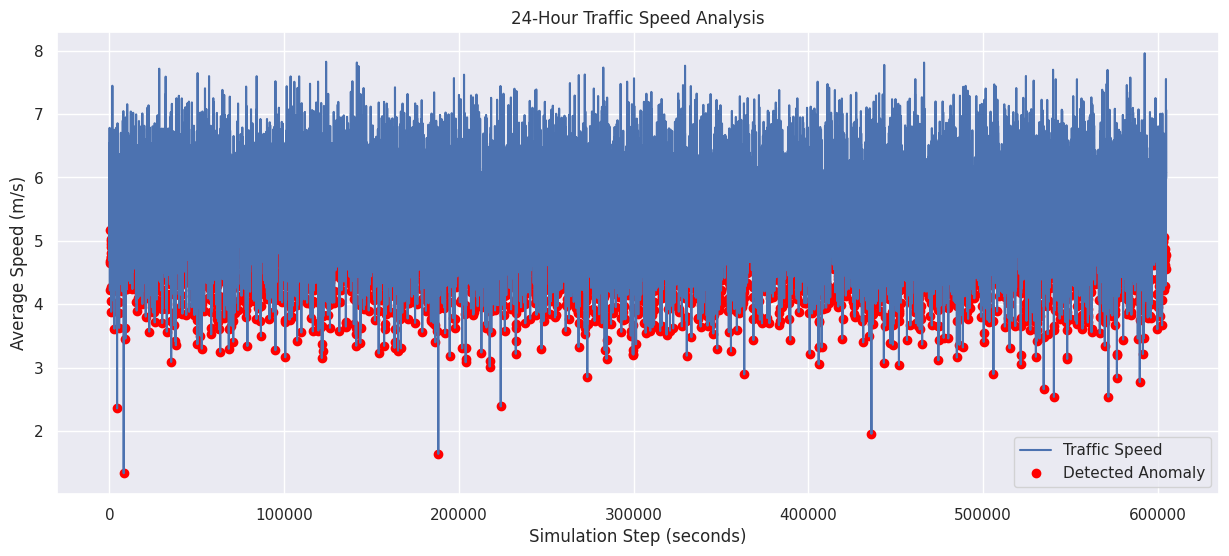

In [55]:
if __name__ == "__main__":
    simulation_data = run_simulation()
    if not simulation_data.empty:
        analyze_and_detect(simulation_data)

Generating polished diagnostic report for Isolation Forest...
Report saved as 'iforest_analysis_report.png'


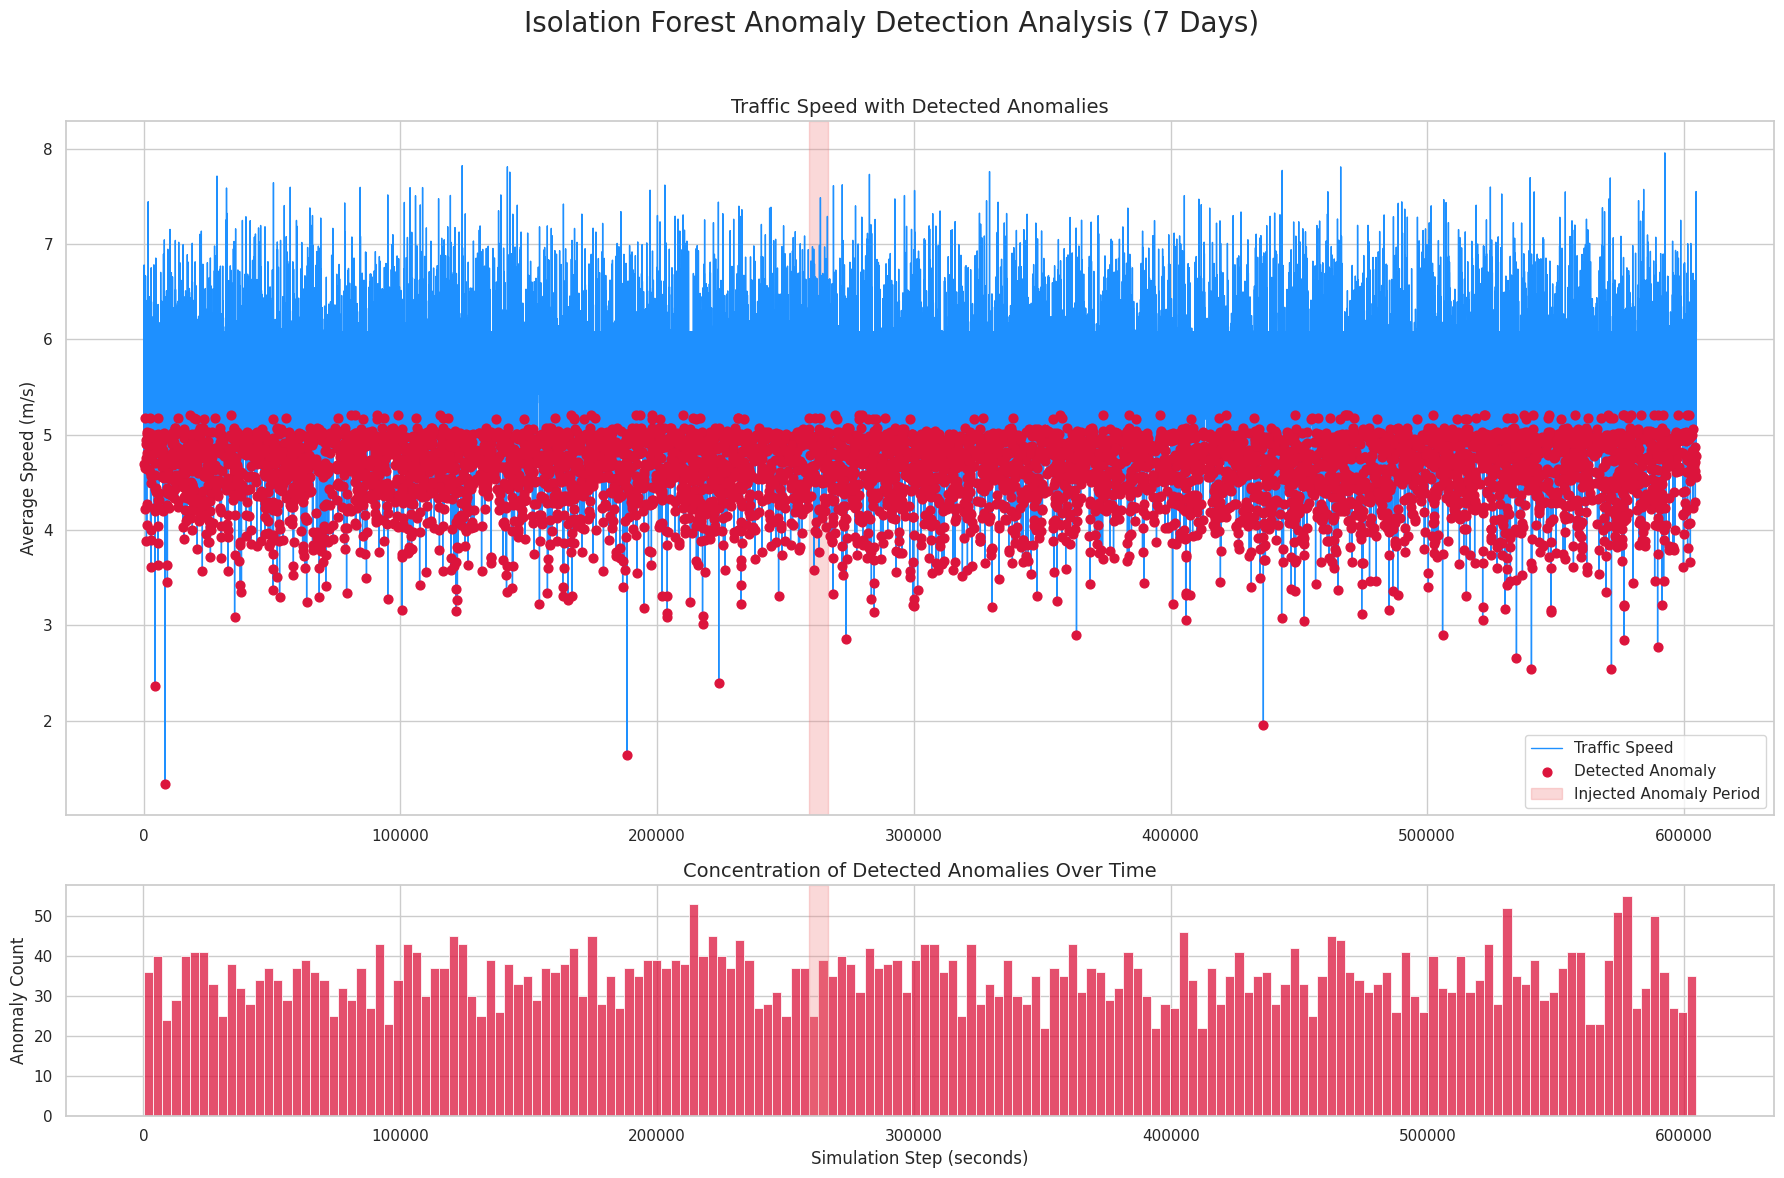

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_iforest_report(df):
    """
    Generates a single, report-quality figure with two diagnostic plots
    for the Isolation Forest results and saves it to a file.
    """
    print("Generating polished diagnostic report for Isolation Forest...")

    # --- Data Preparation ---
    anomalies = df[df['anomaly_score'] == -1]
    
    # Define the ground truth anomaly period from your main script's configuration
    # This is for the 7-day simulation run
    anomaly_start = 259200  # Day 3
    anomaly_end = anomaly_start + 7200 # 2-hour duration

    # --- Plotting Setup ---
    sns.set_theme(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle('Isolation Forest Anomaly Detection Analysis (7 Days)', fontsize=20)

    # --- Subplot 1: Anomaly Detections Over Time ---
    ax1.plot(df['step'], df['speed'], label='Traffic Speed', color='dodgerblue', linewidth=1)
    ax1.scatter(anomalies['step'], anomalies['speed'], color='crimson', label='Detected Anomaly', s=40, zorder=5)
    ax1.axvspan(anomaly_start, anomaly_end, color='lightcoral', alpha=0.3, label='Injected Anomaly Period')
    
    ax1.set_title('Traffic Speed with Detected Anomalies', fontsize=14)
    ax1.set_ylabel('Average Speed (m/s)', fontsize=12)
    ax1.legend()

    # --- Subplot 2: Histogram of Anomaly Occurrences ---
    sns.histplot(data=anomalies, x='step', bins=168, ax=ax2, color='crimson') # 1 bin per hour
    ax2.axvspan(anomaly_start, anomaly_end, color='lightcoral', alpha=0.3)
    
    ax2.set_title('Concentration of Detected Anomalies Over Time', fontsize=14)
    ax2.set_xlabel('Simulation Step (seconds)', fontsize=12)
    ax2.set_ylabel('Anomaly Count', fontsize=12)
    
    # --- Finalize and Save ---
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("iforest_analysis_report.png", dpi=300)
    print("Report saved as 'iforest_analysis_report.png'")
    
    plt.show()

# --- Main Execution Block ---
if __name__ == "__main__":
    try:
        results_df = pd.read_csv("isolation_forest_results.csv")
        create_iforest_report(results_df)
    except FileNotFoundError:
        print("Error: 'isolation_forest_results.csv' not found.")
        print("Please run your main simulation script first to generate the results file.")

# 7-Day Simulation 

In [58]:
import traci
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# --- Configuration ---
SIMULATION_DURATION = 604800 # 7 days in seconds
ANOMALY_START_TIME = 259200  # Anomaly starts on Day 3
ANOMALY_DURATION = 7200      # Anomaly lasts for 2 hours

In [59]:
def inject_anomaly(time, monitored_edge, anomaly_info):
    """Injects and clears a lane closure anomaly."""
    # (Code is identical to the 24-hour version)
    if time > ANOMALY_START_TIME and not anomaly_info['injected']:
        if traci.edge.getLaneNumber(monitored_edge) > 0:
            lane_id = f"{monitored_edge}_0"
            traci.lane.setDisallowed(lane_id, ["passenger"]) 
            anomaly_info['injected'] = True
            anomaly_info['start_time'] = time
            print(f"--- ANOMALY: Lane {lane_id} closed at step {time} ---")

    if anomaly_info['injected'] and not anomaly_info['cleared']:
        if time > anomaly_info['start_time'] + ANOMALY_DURATION:
            lane_id = f"{monitored_edge}_0"
            traci.lane.setDisallowed(lane_id, [])
            anomaly_info['cleared'] = True
            print(f"--- ANOMALY CLEARED: Lane {lane_id} reopened at step {time} ---")

In [60]:
def run_simulation():
    """Starts SUMO, runs the simulation, and collects data."""
    # Use "sumo" for no GUI, which is much faster for long simulations.
    sumo_binary = "sumo" 
    sumo_cmd = [sumo_binary, "-c", "map.sumocfg", "--ignore-route-errors"]
    traci.start(sumo_cmd)
    
    # (The rest of the code is identical to the 24-hour version)
    monitored_edge = traci.edge.getIDList()[0]
    print(f"Monitoring edge: {monitored_edge}")
    data = []
    anomaly_info = {'injected': False, 'cleared': False, 'start_time': -1}
    
    while traci.simulation.getMinExpectedNumber() > 0 or traci.simulation.getTime() < SIMULATION_DURATION:
        time = traci.simulation.getTime()
        inject_anomaly(time, monitored_edge, anomaly_info)
        traci.simulationStep()
        speed = traci.edge.getLastStepMeanSpeed(monitored_edge)
        data.append({'step': time, 'speed': speed})
        
    print(f"--- Simulation loop ended at simulation time: {traci.simulation.getTime()} seconds ---")
    traci.close()
    return pd.DataFrame(data)

In [61]:
def analyze_and_detect(df):
    """Analyzes the collected data using an Isolation Forest model."""
    print("\nAnalyzing data with Isolation Forest...")
    X = df[['speed']].values
    
    # Adjust contamination for a 2-hour anomaly in a 168-hour (7-day) simulation.
    model = IsolationForest(contamination=(ANOMALY_DURATION/SIMULATION_DURATION), random_state=42)
    df['anomaly_score'] = model.fit_predict(X)
    anomalies = df[df['anomaly_score'] == -1]
    
    print("\n--- Detected Anomalies (Isolation Forest) ---")
    print(anomalies)

    # (Plotting code is identical to the 24-hour version, except for the title)
    plt.figure(figsize=(15, 6))
    plt.plot(df['step'], df['speed'], label='Traffic Speed')
    plt.scatter(anomalies['step'], anomalies['speed'], color='red', label='Detected Anomaly')
    plt.title('7-Day Traffic Speed Analysis')
    plt.xlabel('Simulation Step (seconds)')
    plt.ylabel('Average Speed (m/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [62]:
def analyze_and_detect(df):
    """Analyzes the collected data using an Isolation Forest model."""
    print("\nAnalyzing data with Isolation Forest...")
    X = df[['speed']].values
    
    # Adjust contamination for a 2-hour anomaly in a 168-hour (7-day) simulation.
    model = IsolationForest(contamination=(ANOMALY_DURATION/SIMULATION_DURATION), random_state=42)
    df['anomaly_score'] = model.fit_predict(X)
    anomalies = df[df['anomaly_score'] == -1]
    
    # --- UPDATE THIS LINE WITH THE NEW FILENAME ---
    df.to_csv("isolation_forest_results_7day.csv", index=False)
    print("\nFull dataset saved to 'isolation_forest_results_7day.csv'")
    
    print("\n--- Detected Anomalies (Isolation Forest) ---")
    print(anomalies)

    # (The rest of the function remains the same)
    plt.figure(figsize=(15, 6))
    plt.plot(df['step'], df['speed'], label='Traffic Speed')
    plt.scatter(anomalies['step'], anomalies['speed'], color='red', label='Detected Anomaly')
    plt.title('7-Day Traffic Speed Analysis')
    plt.xlabel('Simulation Step (seconds)')
    plt.ylabel('Average Speed (m/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

Generating polished diagnostic report for 7-Day Isolation Forest...
Report saved as 'iforest_analysis_report_7day.png'


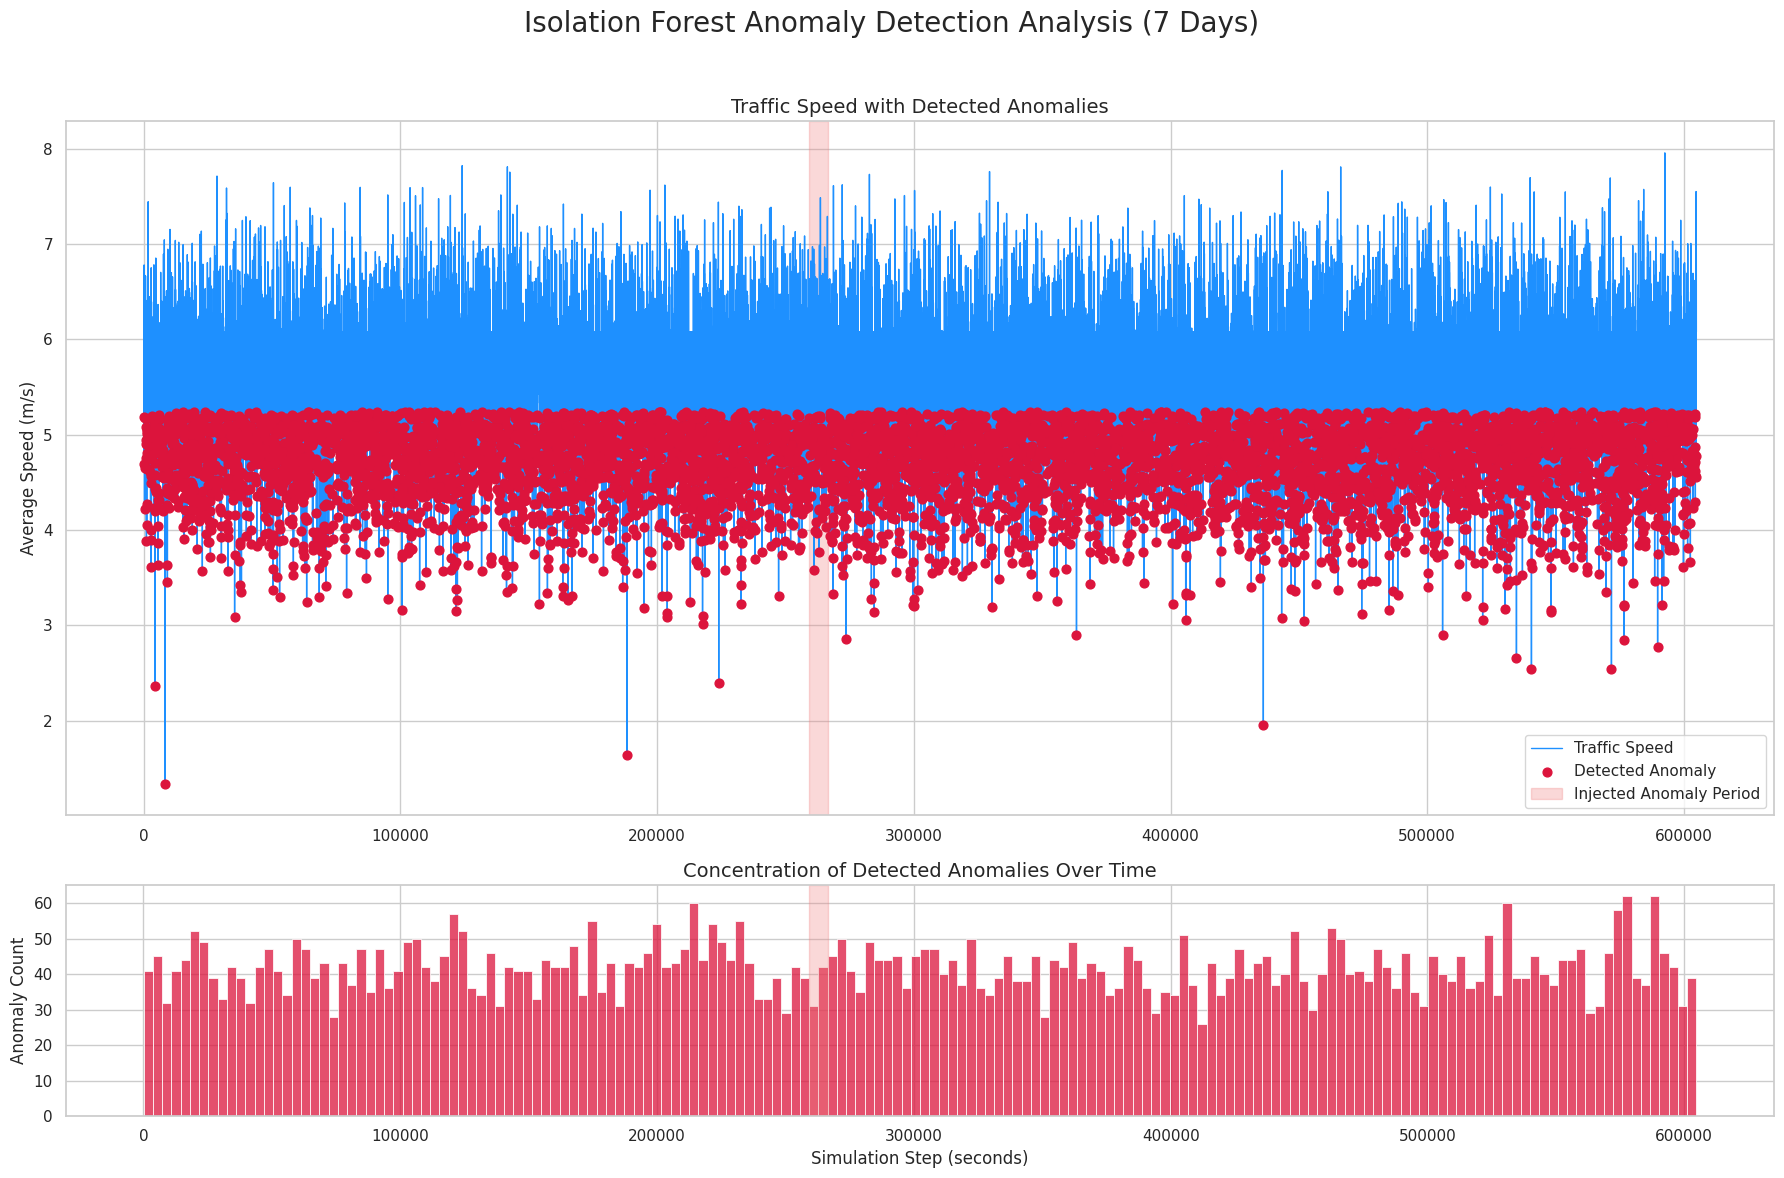

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_iforest_report_7day(df):
    """
    Generates a polished, two-part report for the 7-day 
    Isolation Forest results and saves it to a file.
    """
    print("Generating polished diagnostic report for 7-Day Isolation Forest...")

    # --- Data Preparation ---
    anomalies = df[df['anomaly_score'] == -1]
    
    # Define the ground truth anomaly period from the 7-day script
    anomaly_start = 259200  # Day 3
    anomaly_end = anomaly_start + 7200   # 2-hour duration

    # --- Plotting Setup ---
    sns.set_theme(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle('Isolation Forest Anomaly Detection Analysis (7 Days)', fontsize=20)

    # --- Subplot 1: Anomaly Detections Over Time ---
    ax1.plot(df['step'], df['speed'], label='Traffic Speed', color='dodgerblue', linewidth=1)
    ax1.scatter(anomalies['step'], anomalies['speed'], color='crimson', label='Detected Anomaly', s=40, zorder=5)
    ax1.axvspan(anomaly_start, anomaly_end, color='lightcoral', alpha=0.3, label='Injected Anomaly Period')
    
    ax1.set_title('Traffic Speed with Detected Anomalies', fontsize=14)
    ax1.set_ylabel('Average Speed (m/s)', fontsize=12)
    ax1.legend()

    # --- Subplot 2: Histogram of Anomaly Occurrences ---
    sns.histplot(data=anomalies, x='step', bins=168, ax=ax2, color='crimson') # 1 bin per hour for 7 days
    ax2.axvspan(anomaly_start, anomaly_end, color='lightcoral', alpha=0.3)
    
    ax2.set_title('Concentration of Detected Anomalies Over Time', fontsize=14)
    ax2.set_xlabel('Simulation Step (seconds)', fontsize=12)
    ax2.set_ylabel('Anomaly Count', fontsize=12)
    
    # --- Finalize and Save ---
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("iforest_analysis_report_7day.png", dpi=300)
    print("Report saved as 'iforest_analysis_report_7day.png'")
    
    plt.show()

# --- Main Execution Block ---
if __name__ == "__main__":
    try:
        # Load the results from the specific 7-day file
        results_df = pd.read_csv("isolation_forest_results_7day.csv")
        create_iforest_report_7day(results_df)
    except FileNotFoundError:
        print("Error: 'isolation_forest_results_7day.csv' not found.")
        print("Please run your main 7-day simulation script first to generate the results file.")

 Retrying in 1 seconds
Monitoring edge: :A0_0
--- ANOMALY: Lane :A0_0_0 closed at step 259201.0 ---
Step #265500.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 6--- ANOMALY CLEARED: Lane :A0_0_0 reopened at step 266402.0 ---
--- Simulation loop ended at simulation time: 604847.0 seconds ---CT 9 BUF 0)             
Step #604847.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 151200 ACT 0 BUF 0)             

Analyzing data with Isolation Forest...

Full dataset saved to 'isolation_forest_results_7day.csv'

--- Detected Anomalies (Isolation Forest) ---
            step     speed  anomaly_score
103        103.0  4.690546             -1
186        186.0  5.190189             -1
294        294.0  4.218892             -1
295        295.0  4.655526             -1
376        376.0  5.171783             -1
...          ...       ...            ...
604450  604450.0  4.866831             -1
604451  604451.0  4.295794             -1
604453  604453.0  4.712749             -1
604564  604564.0  4.556275  

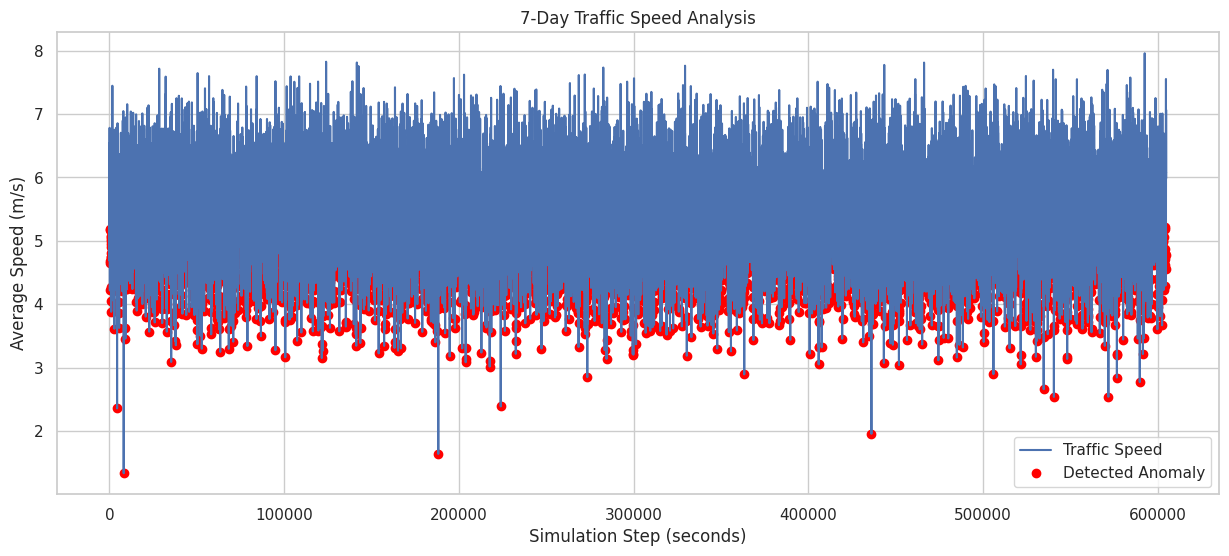

In [64]:
if __name__ == "__main__":
    simulation_data = run_simulation()
    if not simulation_data.empty:
        analyze_and_detect(simulation_data)

# ANOMALIES DETECTION WITH LSTM

In [25]:
import traci
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings

# Suppress the specific UserWarning from sklearn
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.utils.validation')

# --- Configuration ---
NORMAL_SIM_DURATION = 86400  # 24 hours for training data
ANOMALY_SIM_DURATION = 3600  # 1 hour for testing
SEQUENCE_LENGTH = 60         # Use the last 60s of data to predict the next value
EPOCHS = 20                  # Increased epochs for better training
THRESHOLD_MULTIPLIER = 2.5   # Higher multiplier to reduce sensitivity to noise

def run_normal_simulation(duration):
    """Runs a simulation with ONLY normal traffic to generate training data."""
    print("Running simulation to generate normal training data...")
    sumo_cmd = ["sumo", "-c", "map.sumocfg", "--ignore-route-errors"]
    traci.start(sumo_cmd)
    
    monitored_edge = traci.edge.getIDList()[0]
    speeds = []
    while traci.simulation.getTime() < duration:
        traci.simulationStep()
        speeds.append(traci.edge.getLastStepMeanSpeed(monitored_edge))
    
    traci.close()
    print("Normal data generation finished.")
    return pd.DataFrame(speeds, columns=['speed'])

def train_lstm_model(speed_df):
    """Prepares data and trains the LSTM model."""
    print(f"Training LSTM model for {EPOCHS} epochs...")
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # IMPROVEMENT: Use .values to pass a NumPy array and prevent sklearn warnings
    scaled_data = scaler.fit_transform(speed_df[['speed']].values)

    X_train, y_train = [], []
    for i in range(SEQUENCE_LENGTH, len(scaled_data)):
        X_train.append(scaled_data[i-SEQUENCE_LENGTH:i, 0])
        y_train.append(scaled_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(X_train, y_train, batch_size=64, epochs=EPOCHS, verbose=1)

    train_predict = model.predict(X_train)
    train_mae_loss = np.mean(np.abs(train_predict - y_train[:, np.newaxis]), axis=1)
    threshold = np.max(train_mae_loss) * THRESHOLD_MULTIPLIER
    
    print(f"Anomaly detection threshold (MAE): {threshold}")
    print("Model training complete.")
    return model, scaler, threshold

def predictive_detection_simulation(model, scaler, threshold):
    """Runs a new simulation with an anomaly and performs live detection."""
    print("\nStarting simulation with predictive anomaly detection...")
    sumo_cmd = ["sumo-gui", "-c", "map.sumocfg", "--ignore-route-errors"]
    traci.start(sumo_cmd)

    monitored_edge = traci.edge.getIDList()[0]
    speed_history = []
    results = []
    anomaly_injected = False

    while traci.simulation.getTime() < ANOMALY_SIM_DURATION:
        time = traci.simulation.getTime()
        if time > 1000 and not anomaly_injected:
            traci.lane.setDisallowed(f"{monitored_edge}_0", ["passenger"])
            anomaly_injected = True
            print(f"--- ANOMALY INJECTED at step {time} ---")
            
        traci.simulationStep()
        current_speed = traci.edge.getLastStepMeanSpeed(monitored_edge)
        speed_history.append(current_speed)

        if len(speed_history) > SEQUENCE_LENGTH:
            last_sequence = np.array(speed_history[-SEQUENCE_LENGTH:]).reshape(-1, 1)
            scaled_sequence = scaler.transform(last_sequence)
            input_sequence = np.reshape(scaled_sequence, (1, SEQUENCE_LENGTH, 1))

            predicted_scaled_speed = model.predict(input_sequence, verbose=0)
            predicted_speed = scaler.inverse_transform(predicted_scaled_speed)[0][0]

            if len(speed_history) > SEQUENCE_LENGTH + 1:
                actual_next_speed = speed_history[-1]
                prediction_error = np.abs(predicted_speed - actual_next_speed)
                
                is_anomaly = prediction_error > threshold
                results.append([time, actual_next_speed, predicted_speed, prediction_error, is_anomaly])
                
                if is_anomaly:
                    print(f"Step {int(time)}: ANOMALY DETECTED! "
                          f"Actual: {actual_next_speed:.2f}, "
                          f"Predicted: {predicted_speed:.2f}, "
                          f"Error: {prediction_error:.2f}")

    traci.close()
    return pd.DataFrame(results, columns=['step', 'actual', 'predicted', 'error', 'is_anomaly'])

# --- Main Execution Block ---
if __name__ == "__main__":
    normal_data_df = run_normal_simulation(NORMAL_SIM_DURATION)
    lstm_model, data_scaler, anomaly_threshold = train_lstm_model(normal_data_df)
    detection_results_df = predictive_detection_simulation(lstm_model, data_scaler, anomaly_threshold)

    print("\n--- Detection Complete ---")
    print(detection_results_df[detection_results_df['is_anomaly']].head())

Running simulation to generate normal training data...
 Retrying in 1 seconds
Step #86400.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 21599 ACT 8 BUF 1)               
Normal data generation finished.
Training LSTM model for 20 epochs...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 47s 34ms/step - loss: 0.0112
Epoch 2/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - loss: 8.2493e-04
Epoch 3/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.4979e-04
Epoch 4/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - loss: 7.5607e-04
Epoch 5/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - loss: 7.5087e-04
Epoch 6/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - loss: 7.5947e-04
Epoch 7/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.3996e-04
Epoch 8/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - loss: 7.3139e-04
Epoch 9/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 55s 41ms/step - loss: 7.3844e-04
Epoch 10/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.3778e-04
Epoch 11/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.3814e-04
Epoch 12/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 54s 40ms/step - loss: 7.4237e-04
Epoch 13/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.6039e-04
Epoch 14/20
1350/1350 ━━━━━━━━━━━━━━

Running simulation to generate normal training data...
 Retrying in 1 seconds
Step #86400.00 (1ms ~= 1000.00*RT, ~8000.00UPS, TraCI: 1ms, vehicles TOT 21599 ACT 8 BUF 1
Normal data generation finished.
Training LSTM model for 20 epochs...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - loss: 0.0112
Epoch 2/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.9604e-04
Epoch 3/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.4669e-04
Epoch 4/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.7749e-04
Epoch 5/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - loss: 7.4371e-04
Epoch 6/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.2236e-04
Epoch 7/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - loss: 7.4235e-04
Epoch 8/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.7220e-04
Epoch 9/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 8.0190e-04
Epoch 10/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.3574e-04
Epoch 11/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.0763e-04
Epoch 12/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 49s 36ms/step - loss: 7.1678e-04
Epoch 13/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.3841e-04
Epoch 14/20
1350/1350 ━━━━━━━━━━━━━━

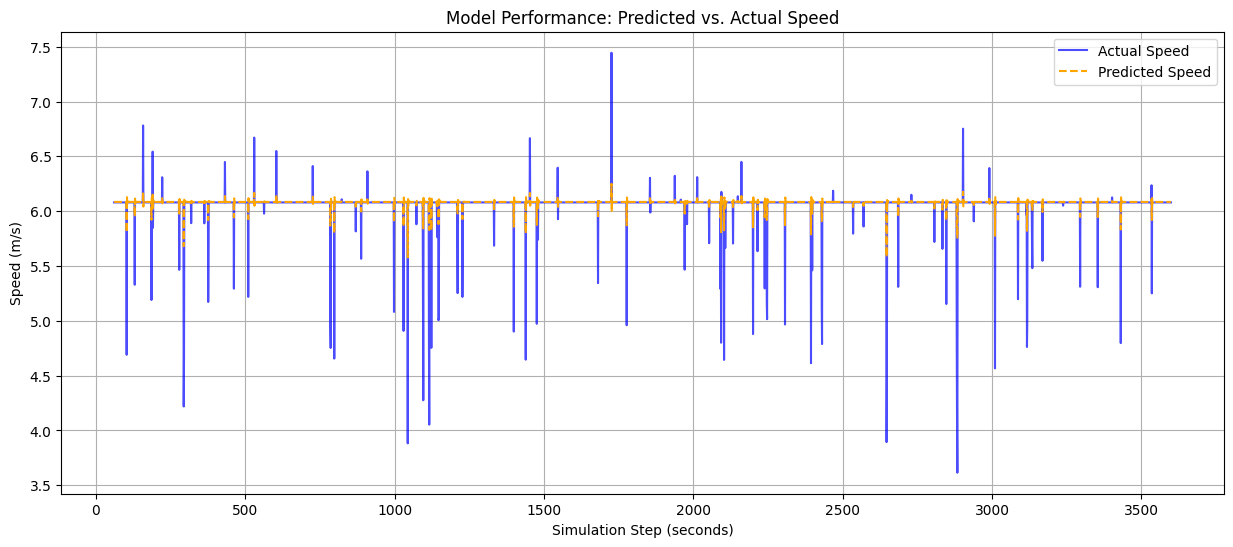


Displaying Anomaly Detection Plot...


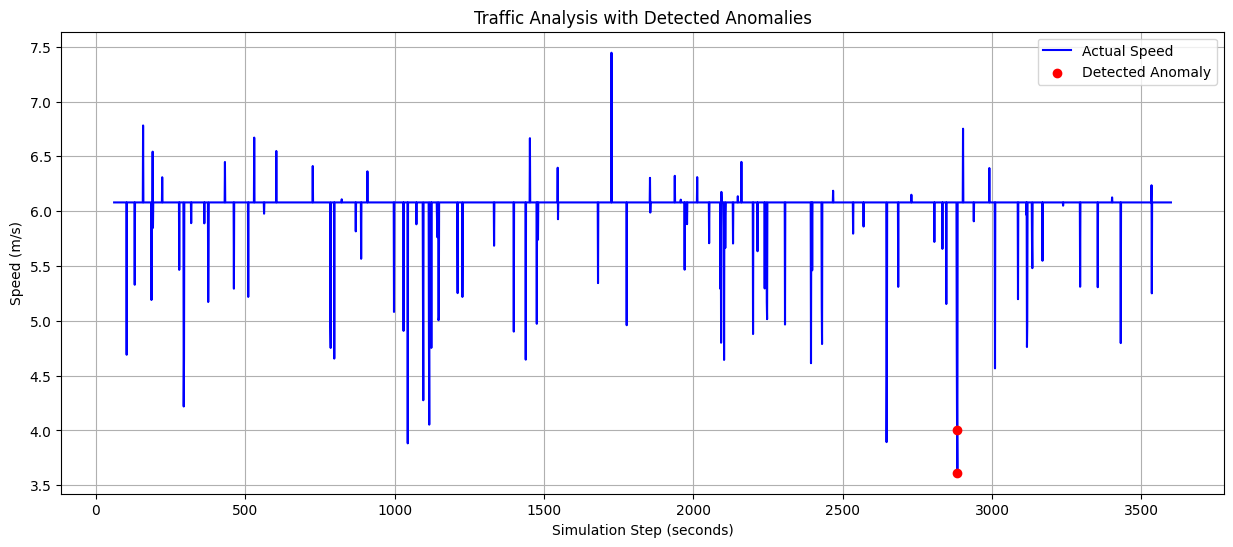

In [26]:
import traci
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings

# Suppress harmless warnings from sklearn
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.utils.validation')

# --- Configuration ---
NORMAL_SIM_DURATION = 86400  # 24 hours for training data
ANOMALY_SIM_DURATION = 3600  # 1 hour for testing
SEQUENCE_LENGTH = 60         # Use the last 60s of data to predict the next value
EPOCHS = 20                  # Number of training epochs
THRESHOLD_MULTIPLIER = 2.5   # Anomaly sensitivity multiplier

def run_normal_simulation(duration):
    """Runs a simulation with ONLY normal traffic to generate training data."""
    print("Running simulation to generate normal training data...")
    sumo_cmd = ["sumo", "-c", "map.sumocfg", "--ignore-route-errors"]
    traci.start(sumo_cmd)
    
    monitored_edge = traci.edge.getIDList()[0]
    speeds = []
    while traci.simulation.getTime() < duration:
        traci.simulationStep()
        speeds.append(traci.edge.getLastStepMeanSpeed(monitored_edge))
    
    traci.close()
    print("Normal data generation finished.")
    return pd.DataFrame(speeds, columns=['speed'])

def train_lstm_model(speed_df):
    """Prepares data and trains the LSTM model."""
    print(f"Training LSTM model for {EPOCHS} epochs...")
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    scaled_data = scaler.fit_transform(speed_df[['speed']].values)

    X_train, y_train = [], []
    for i in range(SEQUENCE_LENGTH, len(scaled_data)):
        X_train.append(scaled_data[i-SEQUENCE_LENGTH:i, 0])
        y_train.append(scaled_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(X_train, y_train, batch_size=64, epochs=EPOCHS, verbose=1)

    train_predict = model.predict(X_train)
    train_mae_loss = np.mean(np.abs(train_predict - y_train[:, np.newaxis]), axis=1)
    threshold = np.max(train_mae_loss) * THRESHOLD_MULTIPLIER
    
    print(f"Anomaly detection threshold (MAE): {threshold}")
    print("Model training complete.")
    return model, scaler, threshold

def predictive_detection_simulation(model, scaler, threshold):
    """Runs a new simulation with an anomaly and performs live detection."""
    print("\nStarting simulation with predictive anomaly detection...")
    sumo_cmd = ["sumo-gui", "-c", "map.sumocfg", "--ignore-route-errors"]
    traci.start(sumo_cmd)

    monitored_edge = traci.edge.getIDList()[0]
    speed_history = []
    results = []
    anomaly_injected = False

    while traci.simulation.getTime() < ANOMALY_SIM_DURATION:
        time = traci.simulation.getTime()
        if time > 1000 and not anomaly_injected:
            traci.lane.setDisallowed(f"{monitored_edge}_0", ["passenger"])
            anomaly_injected = True
            print(f"--- ANOMALY INJECTED at step {time} ---")
            
        traci.simulationStep()
        current_speed = traci.edge.getLastStepMeanSpeed(monitored_edge)
        speed_history.append(current_speed)

        if len(speed_history) > SEQUENCE_LENGTH:
            last_sequence = np.array(speed_history[-SEQUENCE_LENGTH:]).reshape(-1, 1)
            scaled_sequence = scaler.transform(last_sequence)
            input_sequence = np.reshape(scaled_sequence, (1, SEQUENCE_LENGTH, 1))

            predicted_scaled_speed = model.predict(input_sequence, verbose=0)
            predicted_speed = scaler.inverse_transform(predicted_scaled_speed)[0][0]

            if len(speed_history) > SEQUENCE_LENGTH + 1:
                actual_next_speed = speed_history[-1]
                prediction_error = np.abs(predicted_speed - actual_next_speed)
                
                is_anomaly = prediction_error > threshold
                results.append([time, actual_next_speed, predicted_speed, prediction_error, is_anomaly])
                
                if is_anomaly:
                    print(f"Step {int(time)}: ANOMALY DETECTED!")

    traci.close()
    return pd.DataFrame(results, columns=['step', 'actual', 'predicted', 'error', 'is_anomaly'])

def analyze_and_plot_results(df):
    """
    Analyzes the final data, saves it, and creates performance and anomaly plots.
    """
    if df.empty:
        print("No data to analyze.")
        return

    # --- 1. Display and Save the Final Dataset ---
    print("\n--- Final Dataset (First 10 Rows) ---")
    print(df.head(10).to_string())
    
    # Save the complete DataFrame to a CSV file for later analysis
    df.to_csv("detection_results.csv", index=False)
    print("\nFull dataset saved to 'detection_results.csv'")

    # --- 2. Create Model Performance Plot ---
    print("\nDisplaying Model Performance Plot...")
    plt.figure(figsize=(15, 6))
    plt.plot(df['step'], df['actual'], label='Actual Speed', color='blue', alpha=0.7)
    plt.plot(df['step'], df['predicted'], label='Predicted Speed', color='orange', linestyle='--')
    plt.title('Model Performance: Predicted vs. Actual Speed')
    plt.xlabel('Simulation Step (seconds)')
    plt.ylabel('Speed (m/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 3. Create Anomaly Detection Plot ---
    print("\nDisplaying Anomaly Detection Plot...")
    anomalies = df[df['is_anomaly']]
    
    plt.figure(figsize=(15, 6))
    plt.plot(df['step'], df['actual'], label='Actual Speed', color='blue')
    plt.scatter(anomalies['step'], anomalies['actual'], color='red', label='Detected Anomaly', zorder=5)
    plt.title('Traffic Analysis with Detected Anomalies')
    plt.xlabel('Simulation Step (seconds)')
    plt.ylabel('Speed (m/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Main Execution Block ---
if __name__ == "__main__":
    # Generate data and train the model
    normal_data_df = run_normal_simulation(NORMAL_SIM_DURATION)
    lstm_model, data_scaler, anomaly_threshold = train_lstm_model(normal_data_df)
    
    # Run the detection simulation
    detection_results_df = predictive_detection_simulation(lstm_model, data_scaler, anomaly_threshold)
    
    # Analyze, save, and plot the final results
    analyze_and_plot_results(detection_results_df)

Generating Kernel Density Estimation (KDE) plot of errors...


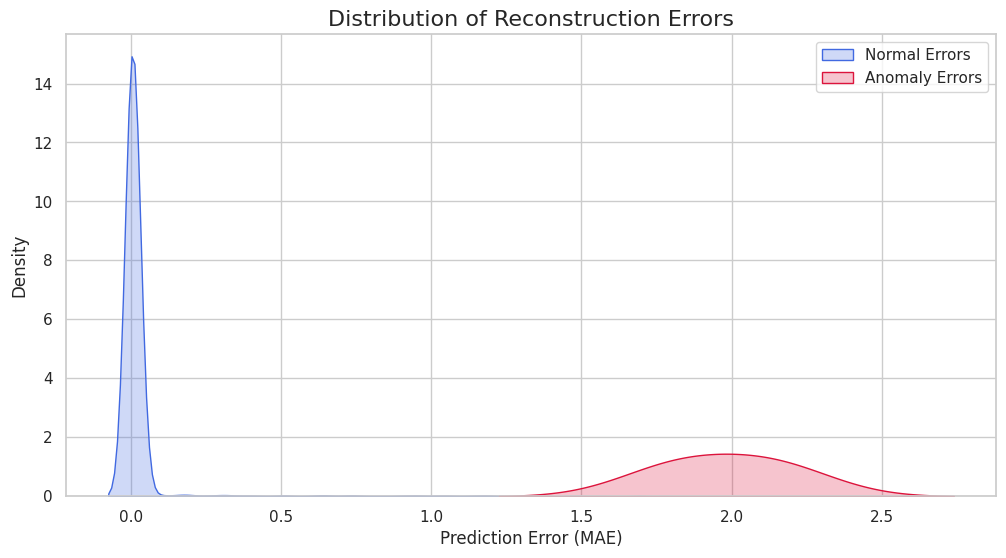

Generating Reconstruction Error time-series plot...


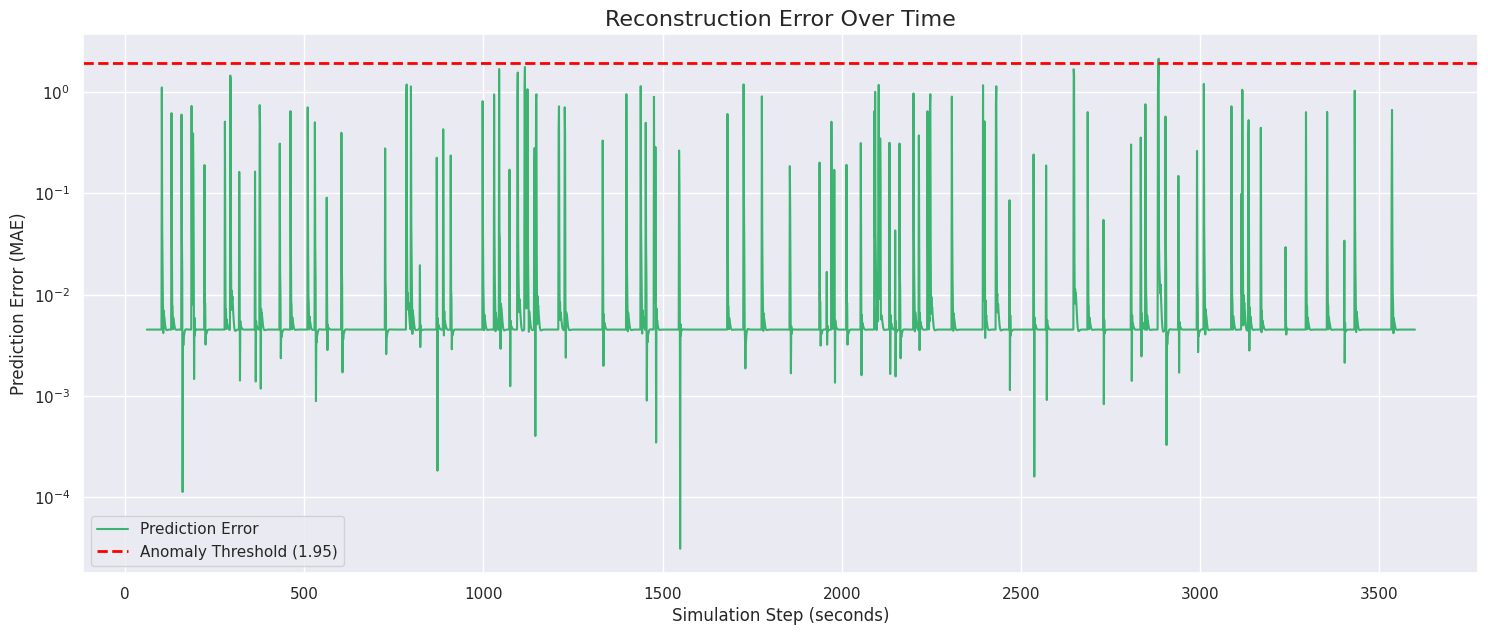

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kde_errors(df):
    """
    Plots the Kernel Density Estimation of reconstruction errors to visualize
    the difference between normal and anomalous data points.
    """
    print("Generating Kernel Density Estimation (KDE) plot of errors...")
    
    # Separate the errors for normal and anomalous points
    normal_errors = df[df['is_anomaly'] == False]['error']
    anomaly_errors = df[df['is_anomaly'] == True]['error']
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    
    # Plot the KDE for both distributions
    sns.kdeplot(normal_errors, fill=True, color="royalblue", label="Normal Errors")
    sns.kdeplot(anomaly_errors, fill=True, color="crimson", label="Anomaly Errors")
    
    plt.title('Distribution of Reconstruction Errors', fontsize=16)
    plt.xlabel('Prediction Error (MAE)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.show()

def plot_error_timeseries(df, threshold):
    """
    Plots the reconstruction error over time and shows the anomaly threshold.
    """
    print("Generating Reconstruction Error time-series plot...")
    
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(18, 7))
    
    # Plot the error over time
    plt.plot(df['step'], df['error'], label='Prediction Error', color='mediumseagreen', linewidth=1.5)
    
    # Draw a horizontal line for the anomaly threshold
    plt.axhline(
        y=threshold, color='red', linestyle='--', linewidth=2, label=f'Anomaly Threshold ({threshold:.2f})'
    )
    
    plt.title('Reconstruction Error Over Time', fontsize=16)
    plt.xlabel('Simulation Step (seconds)', fontsize=12)
    plt.ylabel('Prediction Error (MAE)', fontsize=12)
    plt.legend()
    # Use a logarithmic scale to better visualize the spikes
    plt.yscale('log')
    plt.show()

# --- Main Execution Block ---
if __name__ == "__main__":
    try:
        # Load the results from the file
        results_df = pd.read_csv("detection_results.csv")
        
        # Estimate the threshold from the data to draw the line on the plot
        # This is based on the highest error found on points that were NOT flagged as anomalies.
        non_anomalies = results_df[results_df['is_anomaly'] == False]
        # We add a small buffer (e.g., 10%) for a realistic threshold line
        estimated_threshold = non_anomalies['error'].max() * 1.1 
        
        # Create the plots
        plot_kde_errors(results_df)
        plot_error_timeseries(results_df, estimated_threshold)
        
    except FileNotFoundError:
        print("Error: 'detection_results.csv' not found.")
        print("Please run your main simulation script first to generate the results file.")

In [67]:
# predictive_detector.py
# This script trains an LSTM model and uses it for predictive detection.

import traci
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Suppress harmless warnings from sklearn and Keras
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn|keras')

# --- Configuration ---
# Shorter duration for quick training and testing
NORMAL_SIM_DURATION = 3600   # 1 hour for training data
ANOMALY_SIM_DURATION = 1800  # 30 minutes for testing

# Model parameters
SEQUENCE_LENGTH = 60         # Use last 60s of data to predict the next value
EPOCHS = 20                  # Number of training epochs
THRESHOLD_MULTIPLIER = 2.5   # Anomaly sensitivity multiplier

def run_normal_simulation(duration):
    """Runs a simulation with ONLY normal traffic to generate training data."""
    print(f"Running simulation for {duration} seconds to generate normal training data...")
    sumo_cmd = ["sumo", "-c", "map.sumocfg", "--ignore-route-errors"]
    traci.start(sumo_cmd)
    
    monitored_edge = traci.edge.getIDList()[0]
    speeds = []
    while traci.simulation.getTime() < duration:
        traci.simulationStep()
        speeds.append(traci.edge.getLastStepMeanSpeed(monitored_edge))
    
    traci.close()
    print("Normal data generation finished.")
    return pd.DataFrame(speeds, columns=['speed'])

def train_lstm_model(speed_df):
    """Prepares data and trains the LSTM model."""
    print(f"Training LSTM model for {EPOCHS} epochs...")
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Use .values to pass a NumPy array and prevent sklearn warnings
    scaled_data = scaler.fit_transform(speed_df[['speed']].values)

    # Create sequences of data for time-series prediction
    X_train, y_train = [], []
    for i in range(SEQUENCE_LENGTH, len(scaled_data)):
        X_train.append(scaled_data[i-SEQUENCE_LENGTH:i, 0])
        y_train.append(scaled_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Build the LSTM Neural Network
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train, y_train, batch_size=64, epochs=EPOCHS, verbose=1)

    # Determine the anomaly threshold based on the max training error
    train_predict = model.predict(X_train)
    train_mae_loss = np.mean(np.abs(train_predict - y_train[:, np.newaxis]), axis=1)
    threshold = np.max(train_mae_loss) * THRESHOLD_MULTIPLIER
    
    print(f"Anomaly detection threshold (MAE): {threshold}")
    print("Model training complete.")
    return model, scaler, threshold

def predictive_detection_simulation(model, scaler, threshold):
    """Runs a new simulation with an anomaly and performs live detection."""
    print("\nStarting simulation with predictive anomaly detection...")
    sumo_cmd = ["sumo-gui", "-c", "map.sumocfg", "--ignore-route-errors"]
    traci.start(sumo_cmd)

    monitored_edge = traci.edge.getIDList()[0]
    speed_history = []
    results = []
    anomaly_injected = False

    while traci.simulation.getTime() < ANOMALY_SIM_DURATION:
        time = traci.simulation.getTime()
        
        # Inject an anomaly (lane closure) after 500 seconds
        if time > 500 and not anomaly_injected:
            traci.lane.setDisallowed(f"{monitored_edge}_0", ["passenger"])
            anomaly_injected = True
            print(f"--- ANOMALY INJECTED at step {time} ---")
            
        traci.simulationStep()
        current_speed = traci.edge.getLastStepMeanSpeed(monitored_edge)
        speed_history.append(current_speed)

        # Once we have enough historical data, start predicting
        if len(speed_history) > SEQUENCE_LENGTH:
            # Prepare the most recent data sequence
            last_sequence = np.array(speed_history[-SEQUENCE_LENGTH:]).reshape(-1, 1)
            scaled_sequence = scaler.transform(last_sequence)
            input_sequence = np.reshape(scaled_sequence, (1, SEQUENCE_LENGTH, 1))

            # Predict the next speed value
            predicted_scaled_speed = model.predict(input_sequence, verbose=0)
            predicted_speed = scaler.inverse_transform(predicted_scaled_speed)[0][0]

            # Compare prediction to the actual next value to find the error
            if len(speed_history) > SEQUENCE_LENGTH + 1:
                actual_next_speed = speed_history[-1]
                prediction_error = np.abs(predicted_speed - actual_next_speed)
                
                is_anomaly = prediction_error > threshold
                results.append([time, actual_next_speed, predicted_speed, prediction_error, is_anomaly])
                
                if is_anomaly:
                    print(f"Step {int(time)}: ANOMALY DETECTED! (Error: {prediction_error:.2f})")

    traci.close()
    
    # Create and save the final results DataFrame
    results_df = pd.DataFrame(results, columns=['step', 'actual', 'predicted', 'error', 'is_anomaly'])
    results_df.to_csv("predictive_detection_results.csv", index=False)
    print("\nFull detection results saved to 'predictive_detection_results.csv'")
    
    return results_df

### Main Execution Block ###
if __name__ == "__main__":
    # Step 1: Generate training data from a normal simulation
    normal_data = run_normal_simulation(NORMAL_SIM_DURATION)
    
    # Step 2: Train the LSTM model on the normal data
    lstm_model, data_scaler, anomaly_threshold = train_lstm_model(normal_data)
    
    # Step 3: Run a new simulation and use the model for live predictive detection
    detection_results = predictive_detection_simulation(lstm_model, data_scaler, anomaly_threshold)

    print("\n--- Detection Complete ---")
    print("Anomalies found:")
    print(detection_results[detection_results['is_anomaly']])

Running simulation for 3600 seconds to generate normal training data...
 Retrying in 1 seconds
Step #3600.00 (1ms ~= 1000.00*RT, ~27000.00UPS, TraCI: 1ms, vehicles TOT 1799 ACT 27 BUF 1
Normal data generation finished.
Training LSTM model for 20 epochs...
Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0957
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0073
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0072
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0065
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0052
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0068
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0061
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0055
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0051
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0050
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0047
Epoch 12/20
56/5

Generating polished diagnostic report...
Report saved as 'predictive_model_report.png'


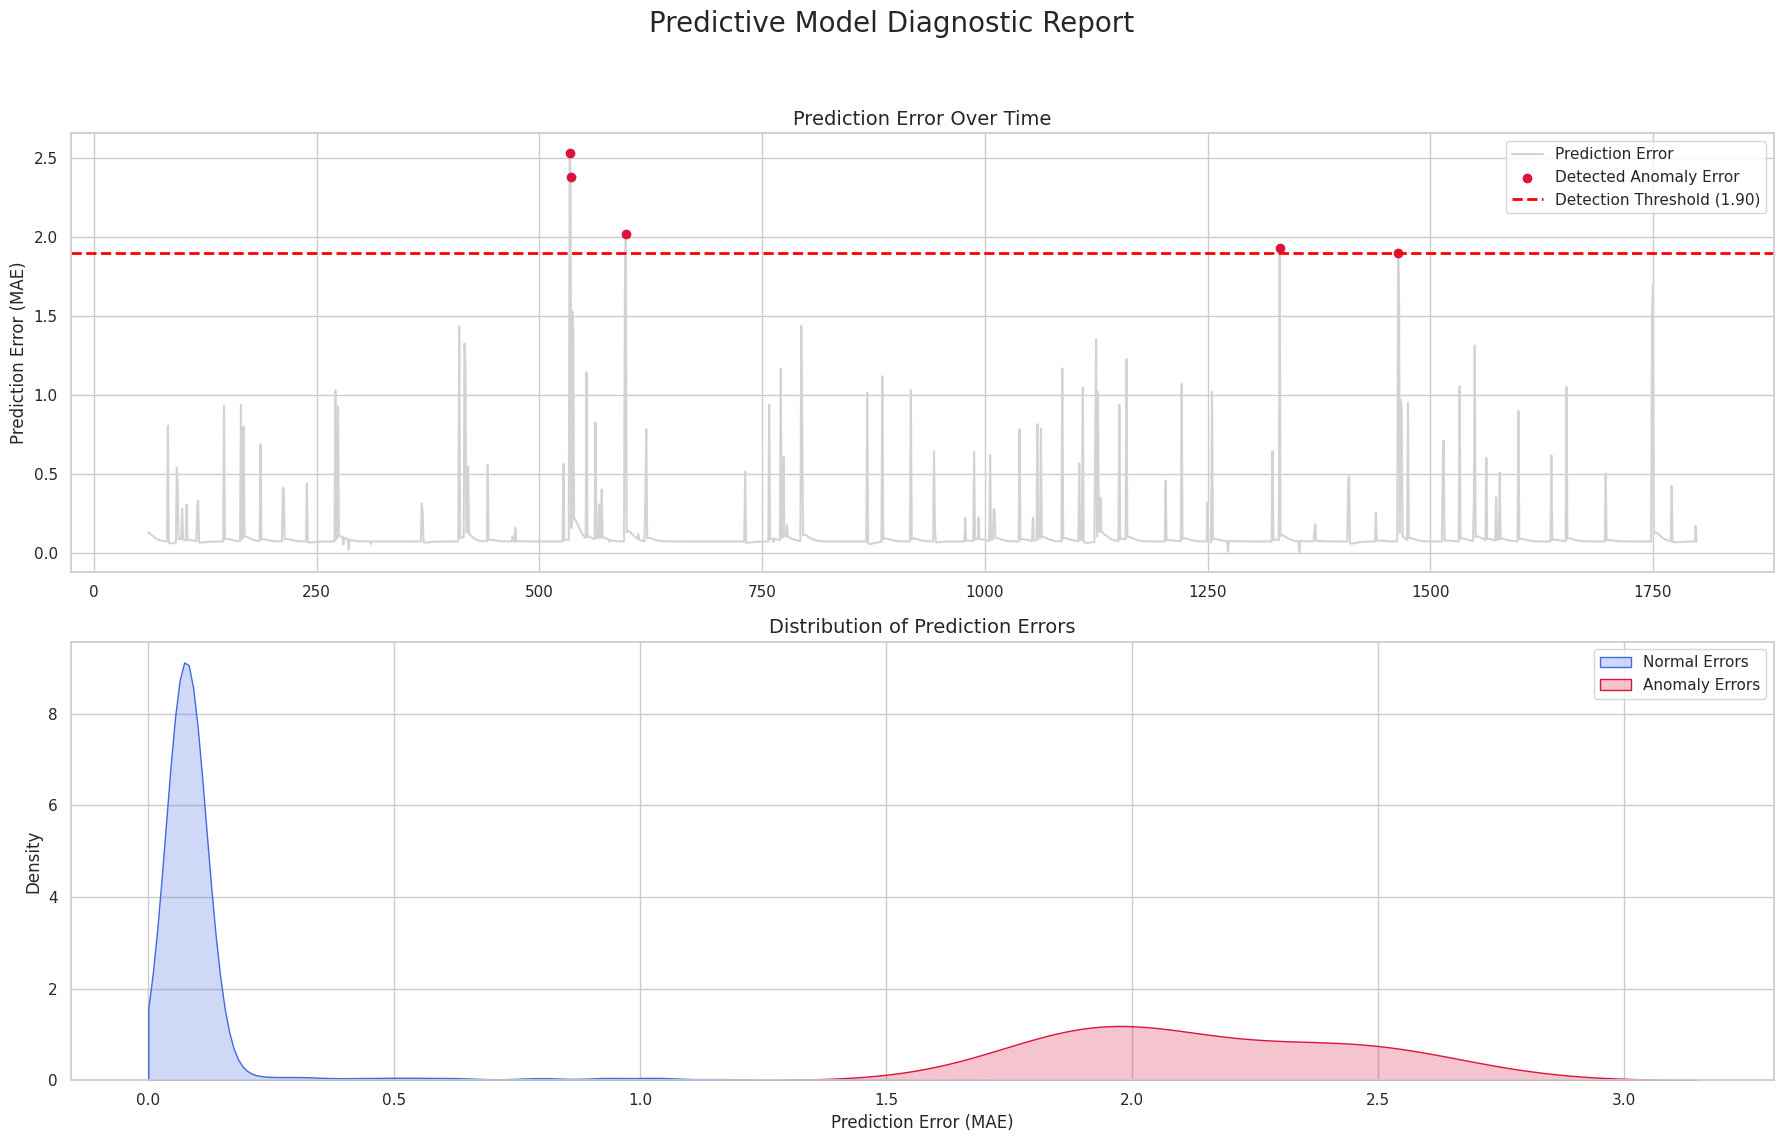

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_diagnostic_report(df):
    """
    Generates a professional, two-part diagnostic plot for the LSTM model's
    performance and saves it to a file.
    """
    print("Generating polished diagnostic report...")
    
    # --- Data Preparation ---
    normal_df = df[df['is_anomaly'] == False]
    anomaly_df = df[df['is_anomaly'] == True]
    
    # The threshold is the minimum error that was flagged as an anomaly
    threshold = anomaly_df['error'].min()

    # --- Plotting Setup ---
    sns.set_theme(style="whitegrid")
    # Create a figure with 2 subplots, one on top of the other
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
    fig.suptitle('Predictive Model Diagnostic Report', fontsize=20)

    # --- Subplot 1: Reconstruction Error Over Time ---
    ax1.plot(df['step'], df['error'], label='Prediction Error', color='lightgray', zorder=1)
    # Highlight the errors of detected anomalies
    ax1.scatter(anomaly_df['step'], anomaly_df['error'], color='crimson', label='Detected Anomaly Error', zorder=2)
    # Draw the threshold line
    ax1.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Detection Threshold ({threshold:.2f})')
    
    ax1.set_title('Prediction Error Over Time', fontsize=14)
    ax1.set_ylabel('Prediction Error (MAE)', fontsize=12)
    ax1.legend()

    # --- Subplot 2: Kernel Density Estimation of Errors ---
    sns.kdeplot(data=normal_df['error'], ax=ax2, fill=True, color="royalblue", label="Normal Errors", clip=(0, None))
    # Only plot anomaly KDE if any anomalies were detected
    if not anomaly_df.empty:
        sns.kdeplot(data=anomaly_df['error'], ax=ax2, fill=True, color="crimson", label="Anomaly Errors", clip=(0, None))
    
    ax2.set_title('Distribution of Prediction Errors', fontsize=14)
    ax2.set_xlabel('Prediction Error (MAE)', fontsize=12)
    ax2.set_ylabel('Density', fontsize=12)
    ax2.legend()
    
    # --- Finalize and Save ---
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for titles
    
    # Save the figure to a high-resolution file
    plt.savefig("predictive_model_report.png", dpi=300)
    print("Report saved as 'predictive_model_report.png'")
    
    plt.show()

# --- Main Execution Block ---
if __name__ == "__main__":
    try:
        # Load the results from the file generated by your main script
        results_df = pd.read_csv("predictive_detection_results.csv")
        create_diagnostic_report(results_df)
        
    except FileNotFoundError:
        print("Error: 'predictive_detection_results.csv' not found.")
        print("Please run your main simulation script first to generate the results file.")

In [1]:
import ping3
import time
import numpy as np

# --- Configuration ---
TARGET_HOST = 'google.com'   # A reliable server to ping
BASELINE_DURATION = 60       # How long to measure normal latency (in seconds)
DELAY_BETWEEN_PINGS = 1      # Time between each ping (in seconds)
ANOMALY_THRESHOLD_STD = 3.0  # How many standard deviations above the average to trigger an alert

def get_live_latency(host):
    """
    Pings a host and returns the latency in milliseconds.
    Returns None if the ping fails.
    """
    try:
        # Send a ping with a 1-second timeout
        delay = ping3.ping(host, unit='ms', timeout=1)
        if delay is not None and delay is not False:
            return delay
    except Exception as e:
        # This can happen if permissions are denied
        print(f"\nError during ping: {e}")
        print("Try running the script with administrator privileges (e.g., 'sudo python ...')")
        exit()
    return None

def establish_baseline():
    """Monitors the network for a set duration to learn normal latency."""
    print(f"Establishing network baseline for {BASELINE_DURATION} seconds...")
    latencies = []
    for i in range(BASELINE_DURATION):
        latency = get_live_latency(TARGET_HOST)
        if latency is not None:
            latencies.append(latency)
            print(f"  Pinging... {latency:.2f} ms")
        else:
            print("  Ping failed.")
        time.sleep(DELAY_BETWEEN_PINGS)
    
    if not latencies:
        print("Could not establish a baseline. Pings may be failing.")
        exit()
        
    # Calculate the normal latency and a threshold for anomalies
    mean_latency = np.mean(latencies)
    std_dev_latency = np.std(latencies)
    anomaly_threshold = mean_latency + (std_dev_latency * ANOMALY_THRESHOLD_STD)
    
    print("\n--- Baseline Established ---")
    print(f"Average Latency: {mean_latency:.2f} ms")
    print(f"Anomaly Threshold set to: {anomaly_threshold:.2f} ms")
    
    return anomaly_threshold

def run_live_detection(threshold):
    """Continuously pings the host and checks for latency spikes."""
    print("\n--- Starting Live Anomaly Detection (Press Ctrl+C to stop) ---")
    try:
        while True:
            latency = get_live_latency(TARGET_HOST)
            
            if latency is not None:
                if latency > threshold:
                    # Use ANSI escape codes for red color
                    print(f"\033[91mANOMALY DETECTED! Latency: {latency:.2f} ms\033[0m")
                else:
                    print(f"Normal. Latency: {latency:.2f} ms")
            else:
                # A failed ping could also be considered an anomaly
                print(f"\033[91mANOMALY DETECTED! Ping failed (possible packet loss).\033[0m")

            time.sleep(DELAY_BETWEEN_PINGS)

    except KeyboardInterrupt:
        print("\n--- Live detection stopped. ---")

# --- Main Execution Block ---
if __name__ == "__main__":
    ping3.EXCEPTIONS = True # Allow exceptions for permission errors
    # 1. Learn what's normal
    learned_threshold = establish_baseline()
    
    # 2. Start watching for anomalies
    run_live_detection(learned_threshold)

Establishing network baseline for 60 seconds...
  Pinging... 18.26 ms
  Pinging... 18.14 ms
  Pinging... 18.19 ms
  Pinging... 18.21 ms
  Pinging... 18.33 ms
  Pinging... 18.22 ms
  Pinging... 18.26 ms
  Pinging... 18.55 ms
  Pinging... 18.55 ms
  Pinging... 18.62 ms
  Pinging... 18.39 ms
  Pinging... 18.38 ms
  Pinging... 18.28 ms
  Pinging... 18.32 ms
  Pinging... 24.69 ms
  Pinging... 18.36 ms
  Pinging... 18.36 ms
  Pinging... 18.30 ms
  Pinging... 18.38 ms
  Pinging... 18.78 ms
  Pinging... 18.37 ms
  Pinging... 19.10 ms
  Pinging... 18.21 ms
  Pinging... 18.81 ms
  Pinging... 18.40 ms
  Pinging... 18.78 ms
  Pinging... 18.39 ms
  Pinging... 18.44 ms
  Pinging... 18.19 ms
  Pinging... 18.33 ms
  Pinging... 21.25 ms
  Pinging... 18.43 ms
  Pinging... 23.60 ms
  Pinging... 18.39 ms
  Pinging... 18.25 ms
  Pinging... 18.35 ms
  Pinging... 18.29 ms
  Pinging... 18.23 ms
  Pinging... 18.20 ms
  Pinging... 18.28 ms
  Pinging... 18.30 ms
  Pinging... 18.30 ms
  Pinging... 18.17 ms
  Ping

Parsing log file: /home/babar/Pictures/ping_log.txt
Generating analytical plot...
Plot saved as 'live_latency_report.png'


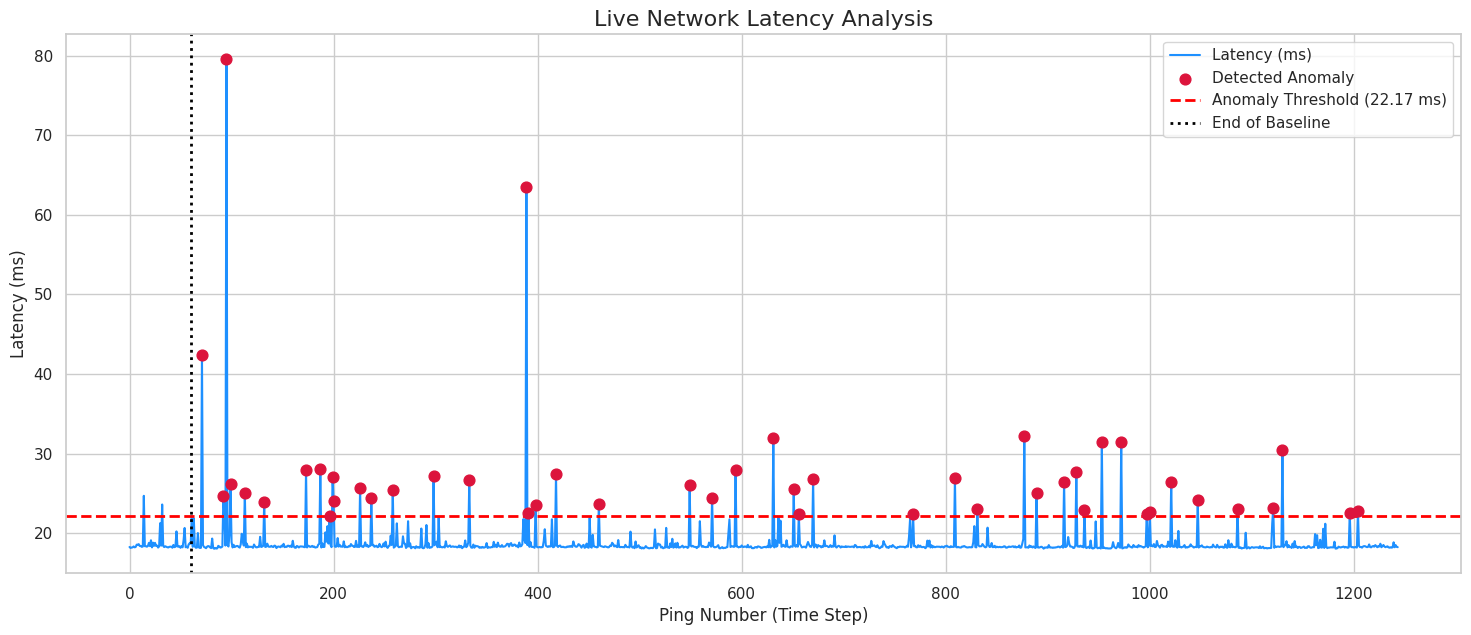

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

def parse_ping_log(log_file_path):
    """
    Reads the text log file and extracts latency data into a pandas DataFrame.
    This version is more robust against malformed lines.
    """
    print(f"Parsing log file: {log_file_path}")
    
    latencies = []
    is_anomaly = []
    threshold = None
    
    # IMPROVEMENT: Use a more specific regex to find latency values.
    # This looks for a floating-point number followed by "ms".
    latency_finder = re.compile(r'(\d+\.\d+)\s*ms')

    with open(log_file_path, 'r') as f:
        for line in f:
            # Find the threshold value from the log
            if "Anomaly Threshold set to:" in line:
                match = latency_finder.search(line)
                if match:
                    threshold = float(match.group(1)) # group(1) gets the value inside the parentheses
            
            # Find a latency value on the line
            match = latency_finder.search(line)
            if match:
                latency_value = float(match.group(1))
                latencies.append(latency_value)
                # Mark if the line contains the anomaly keyword
                is_anomaly.append("ANOMALY DETECTED!" in line)

    if not latencies:
        raise ValueError("Could not find any latency data in the log file.")

    # Create the DataFrame
    df = pd.DataFrame({
        'time_step': range(len(latencies)),
        'latency': latencies,
        'is_anomaly': is_anomaly
    })
    
    return df, threshold

def create_analytical_plot(df, threshold, baseline_duration):
    """
    Creates a single, polished plot from the parsed log data.
    """
    print("Generating analytical plot...")
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(18, 7))
    
    plt.plot(df['time_step'], df['latency'], label='Latency (ms)', color='dodgerblue', linewidth=1.5, zorder=1)
    
    anomalies = df[df['is_anomaly']]
    plt.scatter(anomalies['time_step'], anomalies['latency'], color='crimson', s=60, label='Detected Anomaly', zorder=5)
    
    if threshold:
        plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Anomaly Threshold ({threshold:.2f} ms)')

    plt.axvline(x=baseline_duration, color='black', linestyle=':', linewidth=2, label='End of Baseline')

    plt.title('Live Network Latency Analysis', fontsize=16)
    plt.xlabel('Ping Number (Time Step)', fontsize=12)
    plt.ylabel('Latency (ms)', fontsize=12)
    plt.legend()
    plt.grid(True)
    
    plt.savefig("live_latency_report.png", dpi=300)
    print("Plot saved as 'live_latency_report.png'")
    
    plt.show()

# --- Main Execution Block ---
if __name__ == "__main__":
    LOG_FILENAME = "/home/babar/Pictures/ping_log.txt"
    BASELINE_POINTS = 60 

    try:
        results_df, detected_threshold = parse_ping_log(LOG_FILENAME)
        create_analytical_plot(results_df, detected_threshold, BASELINE_POINTS)
        
    except FileNotFoundError:
        print(f"Error: '{LOG_FILENAME}' not found. Please save your log data to this file first.")
    except Exception as e:
        print(f"An error occurred: {e}")